# Bechdel Test in Film
*Final Report, INFO 2950*<br>
Hal Reed (jhr254)

## Introduction

## Data Description

## Preregistration Statement

This project promised to perform the following analyses:
<ol>
    <li>How has the Bechdel Test passing rate in movie dialogue changed over time?<br>
        <em>Hypothesis: The rate of movies passing the Bechdel Test has increased over time.</em></li><br>
    <li>How does Bechdel Test passing rate vary across movie genres?<br>
        <em>Hypothesis: There is a statistically significant difference between the Bechdel Test passing rates of movies in 
        different genres.</em></li><br>
    <li>How does the passing rate vary with audience movie rating / Does passing the Bechdel Test correlate to higher/lower 
        ratings? <br>
        <em>Hypothesis: Bechdel Test passing rate correlates positively with movie rating.</em></li>
</ol>

## Data Analysis

In [173]:
import pandas as pd
from pathlib import Path
import numpy as np

import json
import csv

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot

In [139]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### Bechdel Test Passing Rate through Time
This visualization will plot the number of movies that passed and the number of movies that failed over the course of the included years.<sup>2, 3, 4</sup>

<AxesSubplot:title={'center':'Bechdel Test Pass/Fail Ratio by Year'}, xlabel='release_year', ylabel='# of films'>

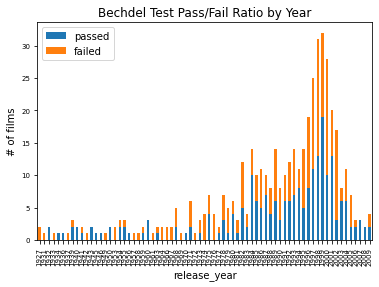

In [202]:
movies_df = pd.read_csv('bechdel_movies.csv')
pass_years = %sql SELECT release_year, COUNT(CASE WHEN bechdel_pass=1 THEN 1 END) as passed, COUNT(CASE WHEN bechdel_pass=0 THEN 0 END) as failed, FROM movies_df GROUP BY release_year
pass_years.plot(x='release_year', kind='bar', stacked=True, title='Bechdel Test Pass/Fail Ratio by Year', rot='90', fontsize='7', ylabel='# of films')

This graph, though not necessarily helpful for running analysis on, gives a good visual cue for the year distribution of the movies which exist in the combination of bechdel test reviews and the ConvoKit data. Some level of how pass/fail rates compare can be observed.

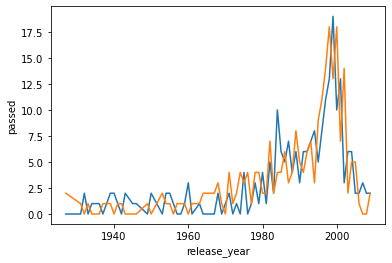

In [141]:
pass_lineplot = sns.lineplot(data=pass_years, x='release_year', y='passed')
pass_lineplot = sns.lineplot(data=pass_years, x='release_year', y='failed')

The above demonstrates a similar relationship between inputs of movies that passed vs. failed the Bechdel Test.

In [142]:
x = np.array(pass_years.release_year)
y_passed = np.array(pass_years.passed)
y2_failed = np.array(pass_years.failed)
y3_diff = y_passed / y2_failed
y3_diff[y3_diff == np.inf] = 0

reg_passed = LinearRegression().fit(x.reshape(-1, 1), y_passed.reshape(-1, 1))
reg_failed = LinearRegression().fit(x.reshape(-1, 1), y2_failed.reshape(-1, 1))
reg_diff = LinearRegression().fit(x.reshape(-1,1), y3_diff.reshape(-1,1))

print('The mean # of test-passing films in a year is:', y_passed.mean())
print('The standard deviation of test-passing films in a year is:', y_passed.std())
print('The slope of the test-passing linear regression model is:', reg_passed.coef_)
print('The intercept of the test-passing linear regression model is:', reg_passed.intercept_)
print('')
print('The mean # of test-failing films in a year is:', y2_failed.mean())
print('The standard deviation of test-failing films in a year is:', y2_failed.std())
print('The slope of the test-failing linear regression model is:', reg_failed.coef_)
print('The intercept of the test-failing linear regression model is:', reg_failed.intercept_)
print('')
print('The mean of the passing/failing ratio films in a year is:', y3_diff.mean())
print('The standard deviation of the passing/failing ratio in a year is:', y3_diff.std())
print('The slope of the ratio of failing/passing linear regression model is:', reg_diff.coef_)
print('The intercept of the failing/passing ratio linear regression model is:', reg_diff.intercept_)


The mean # of test-passing films in a year is: 3.1690140845070425
The standard deviation of test-passing films in a year is: 3.726516764618767
The slope of the test-passing linear regression model is: [[0.09529034]]
The intercept of the test-passing linear regression model is: [-184.74756554]

The mean # of test-failing films in a year is: 3.3943661971830985
The standard deviation of test-failing films in a year is: 4.099051327001478
The slope of the test-failing linear regression model is: [[0.10241897]]
The intercept of the test-failing linear regression model is: [-198.58017659]

The mean of the passing/failing ratio films in a year is: 0.6813648792522032
The standard deviation of the passing/failing ratio in a year is: 0.7834894444486086
The slope of the ratio of failing/passing linear regression model is: [[0.01470486]]
The intercept of the failing/passing ratio linear regression model is: [-28.31724368]


C:\Users\jennh\AppData\Local\Temp\ipykernel_13348\2651084647.py:4: RuntimeWarning: divide by zero encountered in true_divide
  y3_diff = y_passed / y2_failed


The above models assert that, based on the data, there is a general slight (~0.1) increase in both Bechdel-passing *and* -failing films per year. It is worth noting that the ratio of passed:failed films also experiences an increase, though slight, of 0.01 per year.

### Bechdel Test Passing Rate across Genres
These visualizations will compare the passing rate among Genres.

In [211]:
movies_df = pd.read_csv('bechdel_movies.csv')
#convert genre column from str to array
clean_genres=[]
cleanest_genres = []
for x in movies_df['genre']:
    clean_genres.append(x.split())
for x in clean_genres:
    new = []
    for y in x:
        new.append(y.replace('[','').replace(',', '').replace("'", '').replace(']', ''))
    cleanest_genres.append(np.array(new))
movies_df['genre'] = cleanest_genres

#create array of all possible genres
genres = []
for x in cleanest_genres:
    for y in x:
        if y in genres:
            break
        else:
            genres.append(y)

#create array of the num of films per genre
genre_counts = np.zeros(16)
pass_counts = np.zeros(16)
for x in range(0, 16):
    for y in range(0, 466):
        for z in movies_df.genre[y]:
            if z == genres[x]:
                genre_counts[x] +=1
                if movies_df.bechdel_pass[y] == 1:
                    pass_counts[x] +=1

genre_df = pd.DataFrame()
genre_df['genre'] = genres
genre_df['total_films'] = genre_counts
genre_df['passing_films'] = pass_counts
genre_df['pass_percent'] = pass_counts / genre_counts * 100.0

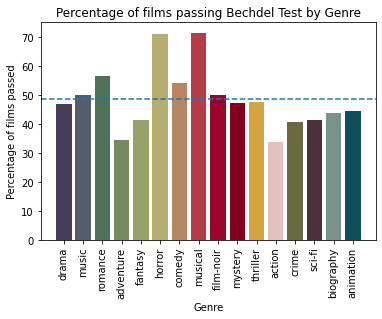

Mean line is at y = 48.37333743952069
Standard Deviation: 10.85435520792138


In [246]:
#draw chart
colors = ['#463c57', '#545d6b', '#4d7159', '#748b5d', '#95a269', '#b6ae71', '#b68663', '#b63b49','#98062d', '#800022', '#d5a43f', '#e1c2bc', '#6b6941', '#4b303d', '#78938a', '#0f4c5c']
pyplot.bar(genre_df['genre'], genre_df['pass_percent'], color=colors)
pyplot.xticks(rotation=90)
pyplot.xlabel('Genre')
pyplot.ylabel('Percentage of films passed')
pyplot.title('Percentage of films passing Bechdel Test by Genre')

#add mean line
mean_percent = genre_df['pass_percent'].mean()
pyplot.axhline(mean_percent, linestyle='--')

pyplot.show()
print('Mean line is at y =', mean_percent)
print('Standard Deviation:', genre_df['pass_percent'].std())

This plot compares the percentage of films in each genre.<sup>5, 6</sup> There seems to be a pretty hefty Standard Deviation at ~10.85, which could note a statistically signficant difference between the passing rate of each logged genre.<br>

Some genres are nearly 40% apart on this metric; for example, adventure and action are just above a 30% pass rate while horror and musicals are around 70%.

### 

## Evaluation of Significance

## Interpretation and Conclusions

## Limitations

## Source Code
The below link to `source-code.ipynb` includes code which was used to clean and merge the Conversations dataset to the scraped Bechdel Test data on shared movies.

https://github.com/jhr254/info2950_gp1/blob/016109f83ee822277d24642a4a4ca87d2d9ed4ff/source-code.ipynb

Cleaning of datasets that did not end up being used for the final report can be found in `archive-code.ipynb` in the same directory as the above.

## Acknowledgments
Superscripts throughout the report refer to the source here.<sup>5</sup>

<sup>1</sup> 
<br> <br>
<sup>2</sup> How to do a stacked bar plot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
<br> <br>
<sup>3</sup> How to use COUNT in SQL for boolean expressions: https://stackoverflow.com/questions/11377446/sql-counting-rows-with-specific-value
<br><br>
<sup>4</sup> How to replace np.inf from division with zeros for modelling purposes: https://pythonguides.com/python-numpy-divide/#:~:text=In%20Python%2C%20if%20we%20want%20to%20divide%20two,a%20true%20division%20of%20the%20input%20array%20element-wise.
<br><br>
<sup>5</sup> Color palette generator used: https://colorkit.co/palettes/10-colors/
<br><br>
<sup>6</sup> Help with horizontal mean line: https://stackoverflow.com/questions/70112634/matplotlib-drawing-a-mean-line
<br><br>
<sup>5</sup> Superscript explanation: https://www.javatpoint.com/superscript-in-markdown

## Appendix: Data Cleaning Description

## Other Appendices